# Metadata_and_polygons
- metadata lat lon all houses dataframe with damage class
- plot json file on top of tif file
- data exploration
- geographical locations of buildings

In [1]:
%%capture
import numpy as np
import pandas as pd
#import geopandas as gpd
import json
import matplotlib.pyplot as plt

from shapely import wkt
import os

#!pip install rasterio
#!pip install geopandas
#!pip install rioxarray

import rasterio as rio
from rasterio.plot import show
from rasterio.warp import transform_bounds
from rasterio.crs import CRS
from rasterio.mask import mask
import geopandas as gpd
import rioxarray as rxr

In [196]:
# from google.colab import drive
# drive.mount('/content/drive')
# data_directory = "/content/drive/MyDrive/ai4er/python/hurricane/hurricane-harm-herald/data/xBD_data"

data_directory = "/Users/Lisanne/Library/CloudStorage/GoogleDrive-lisanneblok@gmail.com/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets"

# Extract imagery and meta-data

In [6]:
# fetch all post disaster json files
import fnmatch
import os

# or list: print([f for f in os.listdir(xbd_json_directory) if fnmatch.fnmatch(f, 'hurricane*post*json')])
def extract_posthurr(which_directory, search_criteria):
  list_of_files = []
  for f in os.listdir(which_directory):
    if fnmatch.fnmatch(f, search_criteria):
      list_of_files.append(f)
  return list_of_files

xbd_json_directory = data_directory + "/geotiffs.old/hold/labels"
posthurr_json_files = extract_posthurr(xbd_json_directory,'hurricane*post*.json')

In [7]:
# Which hurricanes do we have?
def hurricane_labels(posthurr_files ):
  disaster_labels = []
  for label in posthurr_files:
    disaster_type = label.split("_")[0]
    disaster_labels.append(disaster_type)
  return disaster_labels

hurricane_labels = hurricane_labels(posthurr_json_files)
unique_hurricane_labels = list(set(hurricane_labels))
unique_hurricane_labels 

['hurricane-matthew',
 'hurricane-harvey',
 'hurricane-michael',
 'hurricane-florence']

In [8]:
# select specific disaster
disaster_name = unique_hurricane_labels[0]
disaster_name

'hurricane-matthew'

In [18]:
# extract all hurricane_florence json files
#json_search_terms = disaster_name + "*post*json"
#florence_json = extract_posthurr(xbd_json_directory, json_search_terms)
xbd_json_directory = data_directory + "/geotiffs.old/hold/labels"
florence_json = extract_posthurr(xbd_json_directory, 'hurricane*florence*post*.json')

# extract all hurricane florence image files
xbd_tif_directory = data_directory + "/geotiffs.old/hold/images"
#tif_search_terms = disaster_name + "*post*tif"
florence_tif = extract_posthurr(xbd_tif_directory, 'hurricane*florence*post*.tif')

In [19]:
hurr_json = extract_posthurr(xbd_json_directory, 'hurricane*post*.json')

In [20]:
len(hurr_json)

417

# Start plotting

In [23]:
# Convert different damage classes (Joint Damage Scale) into integers
classes_dict = {
    "no-damage": 0,
    "minor-damage": 1,
    "major-damage": 2,
    "destroyed": 3,
    "un-classified": 4
}

In [24]:
def extract_metadata_lonlat(json_link, format, classes_dict):
  json_file = open(json_link)
  json_data = json.load(json_file)
  meta_data = json_data['metadata']
  image_name = meta_data['img_name']
  coordinates = json_data['features']['lng_lat']

  damage_location = []
  damage_dict = {}
  if format == 'point':
      def extract_location(building):
        building_polygon = building['wkt']
        building_coordinates = wkt.loads(building_polygon).centroid.wkt
        return building_coordinates
  if format == 'polygon':
    def extract_location(building):
        building_polygon = building['wkt']
        return building_polygon
  # add exit line if no good answer is given

  for building in coordinates:
    building_loc = extract_location(building)
    damage_class = building['properties']['subtype']
    #damage_num = classes_dict[damage_class]
    
    #damage_location.append([building_loc, damage_num])
    damage_location.append([building_loc, damage_class])
  df = GeoDataFrame(damage_location, columns = ['geometry', 'damage class'])
  #df["geometry"] = df['geometry'].apply(wkt.loads)
  return df, image_name

In [158]:
def extract_metadata(json_link, format, classes_dict):
  json_file = open(json_link)
  json_data = json.load(json_file)
  meta_data = json_data['metadata']
  image_name = meta_data['img_name']
  coordinates = json_data['features']['xy']

  damage_location = []
  damage_dict = {}
  if format == 'point':
      def extract_location(building):
        building_polygon = building['wkt']
        building_coordinates = wkt.loads(building_polygon).centroid.wkt
        return building_coordinates
  if format == 'polygon':
    def extract_location(building):
        building_polygon = building['wkt']
        return building_polygon
  # add exit line if no good answer is given

  for building in coordinates:
    building_loc = extract_location(building)
    damage_class = building['properties']['subtype']

    damage_location.append([building_loc, damage_class])
  df = GeoDataFrame(damage_location, columns = ['geometry', 'damage class'])
  df['geometry'] = df['geometry'].apply(wkt.loads)
  return df, image_name

In [219]:
# json_link = data_directory + "/geotiffs.old/hold/labels/" + florence_json[1]
# json_file = open(json_link)
# json_data = json.load(json_file)
# meta_data = json_data['metadata']
# image_name = meta_data['img_name']
# coordinates = json_data['features']['xy']

# json_data['features']['xy']

# for i in json_data['features']['xy']:
#     #print(i['wkt'])
#    # print('hoi')

In [159]:
from geopandas import GeoDataFrame
json_link = data_directory + "/geotiffs.old/hold/labels/" + florence_json[1]
polygon_damage = extract_metadata(json_link, 'polygon', classes_dict)
polygon_damage

(                                             geometry   damage class
 0   POLYGON ((582.140 423.873, 595.849 416.851, 60...      no-damage
 1   POLYGON ((684.973 492.233, 690.632 487.700, 70...      no-damage
 2   POLYGON ((711.216 505.372, 723.327 499.624, 74...      no-damage
 3   POLYGON ((819.430 691.940, 820.597 694.822, 82...      no-damage
 4   POLYGON ((772.162 748.918, 783.042 745.018, 78...      no-damage
 5   POLYGON ((-0.000 1010.203, 4.200 1017.766, 6.6...      no-damage
 6   POLYGON ((28.626 978.911, 24.709 973.853, 36.6...      no-damage
 7   POLYGON ((99.908 835.264, 121.392 819.020, 142...      no-damage
 8   POLYGON ((421.759 45.365, 449.517 87.679, 428....      no-damage
 9   POLYGON ((290.702 31.523, 298.366 26.213, 308....      no-damage
 10  POLYGON ((150.810 0.009, 143.687 5.915, 138.76...  un-classified
 11  POLYGON ((134.763 0.008, 137.126 2.971, 127.67...  un-classified
 12  POLYGON ((390.798 73.587, 394.644 78.280, 399....      no-damage
 13  POLYGON ((473.8

In [164]:
from PIL import Image, ImageDraw
from IPython.display import display

from rasterio.plot import show

def plot_image_label(json_label, tif_dir, classes_dict):
  # get information on damage and polygons in pandas dataframe
  polygon_damage, image_name = extract_metadata(json_label, 'polygon', classes_dict)

  # plot imagery file
  building_image_path = json_label.replace('labels', 'images').replace('json','tif')
  img = rio.open(building_image_path)

  #img_extent=[img.bounds[0], img.bounds[2], img.bounds[1], img.bounds[3]]
  #print(img_extent)

  f, ax = plt.subplots()
 # ax = rio.plot.show(img.read(), ax=ax, extent = img_extent)
  ax = rio.plot.show(img.read(), ax=ax)
  ax.ticklabel_format(useOffset=False)

  #polygon_damage['geometry'] = gpd.GeoSeries.from_wkt(polygon_damage['geometry'])

  my_geo_df = gpd.GeoDataFrame(polygon_damage, geometry='geometry')
  #my_geo_df.plot(ax=ax, column = "damage class", legend = True, categorical=True, crs="EPSG:4326")
  my_geo_df.plot(ax=ax, column = "damage class", legend = True, categorical=True)
  ax.set_title(image_name)

  print("Ter info: Coordinate reference systems for imagery", img.crs, "and for metadata", my_geo_df.crs)

  return my_geo_df

Ter info: Coordinate reference systems for imagery EPSG:4326 and for metadata None


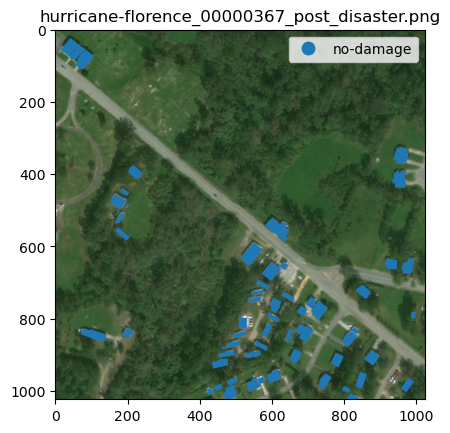

In [165]:
json_dir = data_directory + "/geotiffs.old/hold/labels/"
xbd_tif_directory = data_directory + "/geotiffs.old/hold/images"
specific_label_file = florence_json[3]
json_label = json_dir + "/" + specific_label_file

onthouden = plot_image_label(json_label, xbd_tif_directory, classes_dict)

# Plotting many many images from all hurricanes

In [170]:
def subplot_image_label(json_label, tif_dir, ax):
  # get information on damage and polygons in pandas dataframe
  polygon_damage, image_name = extract_metadata(json_label, 'polygon', classes_dict)

  # plot imagery file
  building_image_path = json_label.replace('labels', 'images').replace('json','tif')
  img = rio.open(building_image_path)
  #img_extent=[img.bounds[0], img.bounds[2], img.bounds[1], img.bounds[3]]
  #ax = rio.plot.show(img.read(), ax=ax, extent=img_extent)
  ax = rio.plot.show(img.read(), ax=ax)
  ax.ticklabel_format(useOffset=False)
  # overlay polygons
  #polygon_damage['geometry'] = gpd.GeoSeries.from_wkt(polygon_damage['geometry'])
  my_geo_df = gpd.GeoDataFrame(polygon_damage, geometry='geometry')
  my_geo_df.plot(ax=ax, column = "damage class", legend = True, categorical=True)

/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


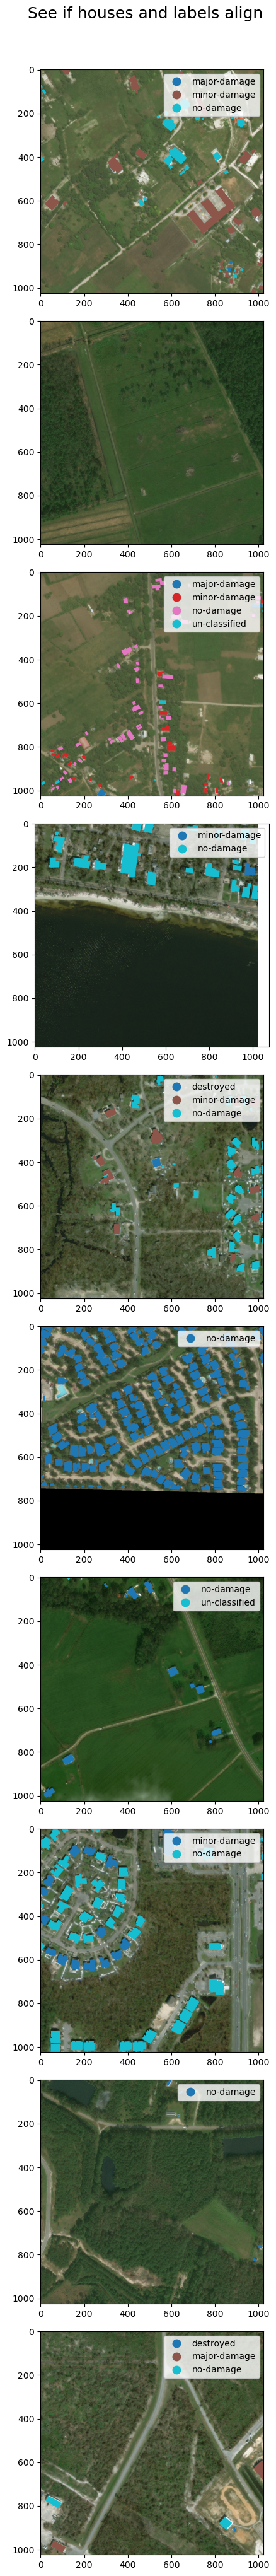

In [171]:
len(hurr_json)
json_xbd_dir = data_directory + "/geotiffs.old/hold/labels/"

sliced_list = hurr_json[:20]
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(50, 40))
fig.tight_layout()
fig.suptitle("See if houses and labels align", fontsize=18, y=1.02)

# loop through axes
for labels, ax in zip(sliced_list, axs.ravel()):
  subplot_image_label(json_xbd_dir+labels, xbd_tif_directory, ax) 

# Make the EF dataset

Problem: locations in JSON file are gridded on image grid. So how to convert to normal coordinates?

In [172]:
def extract_metadata(json_link, classes_dict, format):
  json_file = open(json_link)
  json_data = json.load(json_file)
  meta_data = json_data['metadata']
  disaster_type = meta_data['disaster']
  capture_date = meta_data['capture_date']

  coordinates = json_data['features']['lng_lat']

  damage_location = []
  if format == 'point':
      def extract_location(building):
        building_polygon = building['wkt']
        building_coordinates = wkt.loads(building_polygon).centroid.wkt
        return building_coordinates
  if format == 'polygon':
    def extract_location(building):
        building_polygon = building['wkt']
        return building_polygon

  for building in coordinates:
    building_loc = extract_location(building)
    damage_class = building['properties']['subtype']
    damage_num = classes_dict[damage_class]
    
    damage_location.append([building_loc, damage_num, disaster_type, capture_date])
  df = GeoDataFrame(damage_location, columns = ['geometry', 'damage_class', 'disaster_name', 'capture_date'])
  df["geometry"] = df['geometry'].apply(wkt.loads)
  return df

In [60]:
json_link = data_directory + "/geotiffs.old/hold/labels/" + florence_json[1]
hallo = extract_metadata(json_link, classes_dict, 'point')

In [62]:
def extract_damage_allfiles(full_post_hurr_json_files, type):
  dataframes_list = []
  for file in full_post_hurr_json_files:
    loc_and_damage_df = extract_metadata(file, classes_dict, type)
    dataframes_list.append(loc_and_damage_df)  
  rdf = gpd.GeoDataFrame(pd.concat(dataframes_list, ignore_index=True))
  return rdf

In [82]:
xbd_json_directory = data_directory + "/geotiffs.old/hold/labels"

In [83]:
full_post_hurr_json_files = [xbd_json_directory + "/" + i for i in posthurr_json_files]

df_points_post_hurr = extract_damage_allfiles(full_post_hurr_json_files, 'point')

In [84]:
df_points_post_hurr['capture_date'] = pd.to_datetime(df_points_post_hurr['capture_date'])

In [85]:
df_points_post_hurr['damage_class'].value_counts()

0    10531
1     6192
2     4133
3     1251
4      947
Name: damage_class, dtype: int64

In [34]:
df_points_post_hurr

,geometry,damage_class,disaster_name,capture_date
0,POINT (-77.92443 34.78850),2,hurricane-florence,2018-09-20 16:04:41+00:00
1,POINT (-77.92459 34.78817),1,hurricane-florence,2018-09-20 16:04:41+00:00
2,POINT (-85.61007 30.20004),0,hurricane-michael,2018-10-13 16:48:15+00:00
3,POINT (-85.61057 30.20001),0,hurricane-michael,2018-10-13 16:48:15+00:00
4,POINT (-85.61055 30.20060),1,hurricane-michael,2018-10-13 16:48:15+00:00
...,...,...,...,...
23049,POINT (-77.91797 34.64623),0,hurricane-florence,2018-09-20 16:04:41+00:00
23050,POINT (-77.91773 34.64628),0,hurricane-florence,2018-09-20 16:04:41+00:00
23051,POINT (-77.91765 34.64650),0,hurricane-florence,2018-09-20 16:04:41+00:00
23052,POINT (-77.91835 34.64612),0,hurricane-florence,2018-09-20 16:04:41+00:00


# Data exploration

In [97]:
filepath = data_directory + "/geotiffs.old/hold/df_points_posthurr.pkl"
posthurr_points = pd.read_pickle(filepath)

In [100]:
if posthurr_points.geom_type[0] == None:
    print('Fixing geopandas geometry')
    posthurr_points['geometry'] = gpd.GeoSeries.from_wkt(posthurr_points['geometry'])

Fixing geopandas geometry


In [103]:
posthurr_points.describe()

/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,geometry,damage_class,disaster_name,capture_date
count,23054,23054,23054,23054
unique,23054,5,4,10
top,POINT (-77.9244320492178 34.78850199541164),0,hurricane-harvey,2017-08-31T17:38:50.685Z
freq,1,10531,7226,7187


In [104]:
num_disasters = posthurr_points['disaster_name'].unique()

In [89]:
# use geopandas dataset for world map
countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))

/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/geopandas/plotting.py:807: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cat = pd.Categorical(values, categories=categories)
/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/geopandas/plotting.py:807: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cat = pd.Categorical(values, categories=categories)
/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/geopandas/plotting.py:807: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cat = pd.Categorical(values, categories=categories)
/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/geopandas/plotting.py:807: FutureWarnin

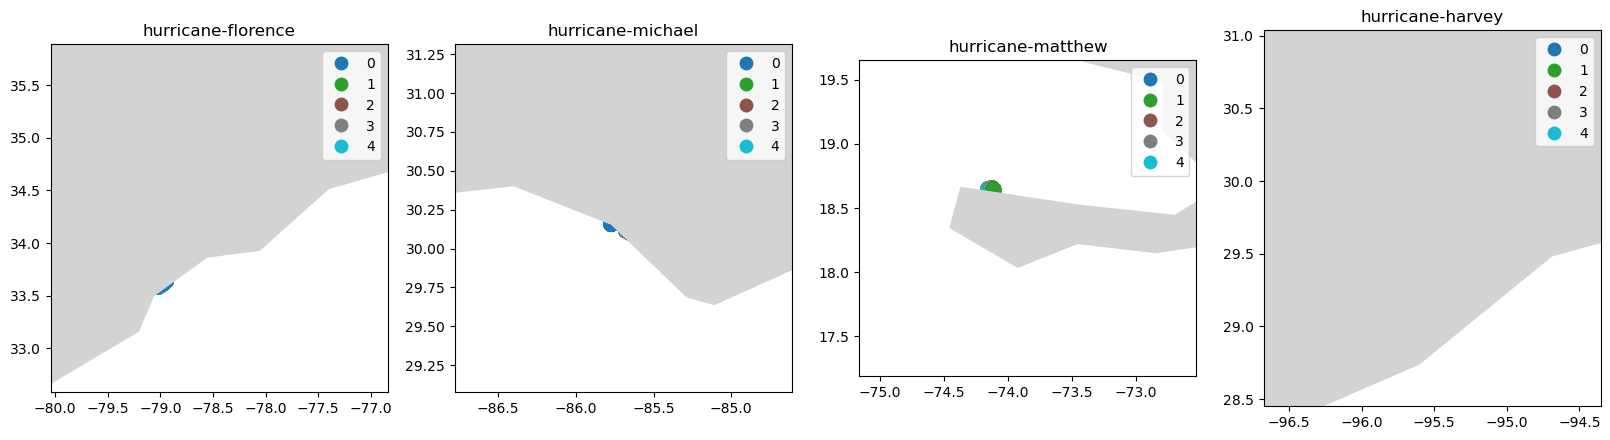

In [105]:
figs, axs = plt.subplots(1, len(num_disasters), figsize = (20,10))

for name, ax in zip(num_disasters, axs.ravel()):
  filtered_df = posthurr_points[posthurr_points['disaster_name'] == name]
  filtered_df.plot(ax=ax, column = "damage_class", legend = True, s=100)
  ax.set_title(name)
  minx, miny, maxx, maxy = filtered_df.total_bounds
  countries.plot(color="lightgrey", ax=ax)
  ax.set_xlim(minx-1, maxx+1)
  ax.set_ylim(miny-1, maxy+1)
  ax.set_xlabel("")


array([[<AxesSubplot:title={'center':'hurricane-florence'}>,
        <AxesSubplot:title={'center':'hurricane-harvey'}>],
       [<AxesSubplot:title={'center':'hurricane-matthew'}>,
        <AxesSubplot:title={'center':'hurricane-michael'}>]], dtype=object)

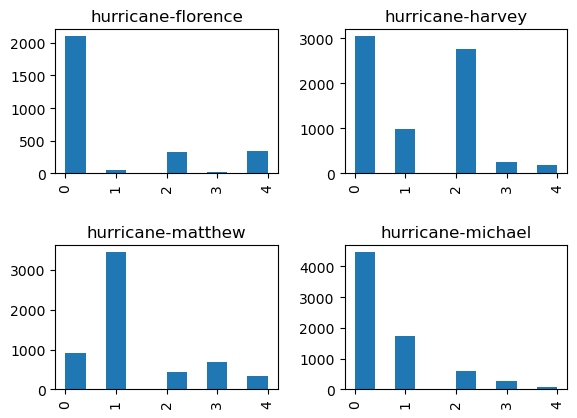

In [106]:
posthurr_points['damage_class'].hist(by=posthurr_points['disaster_name'])

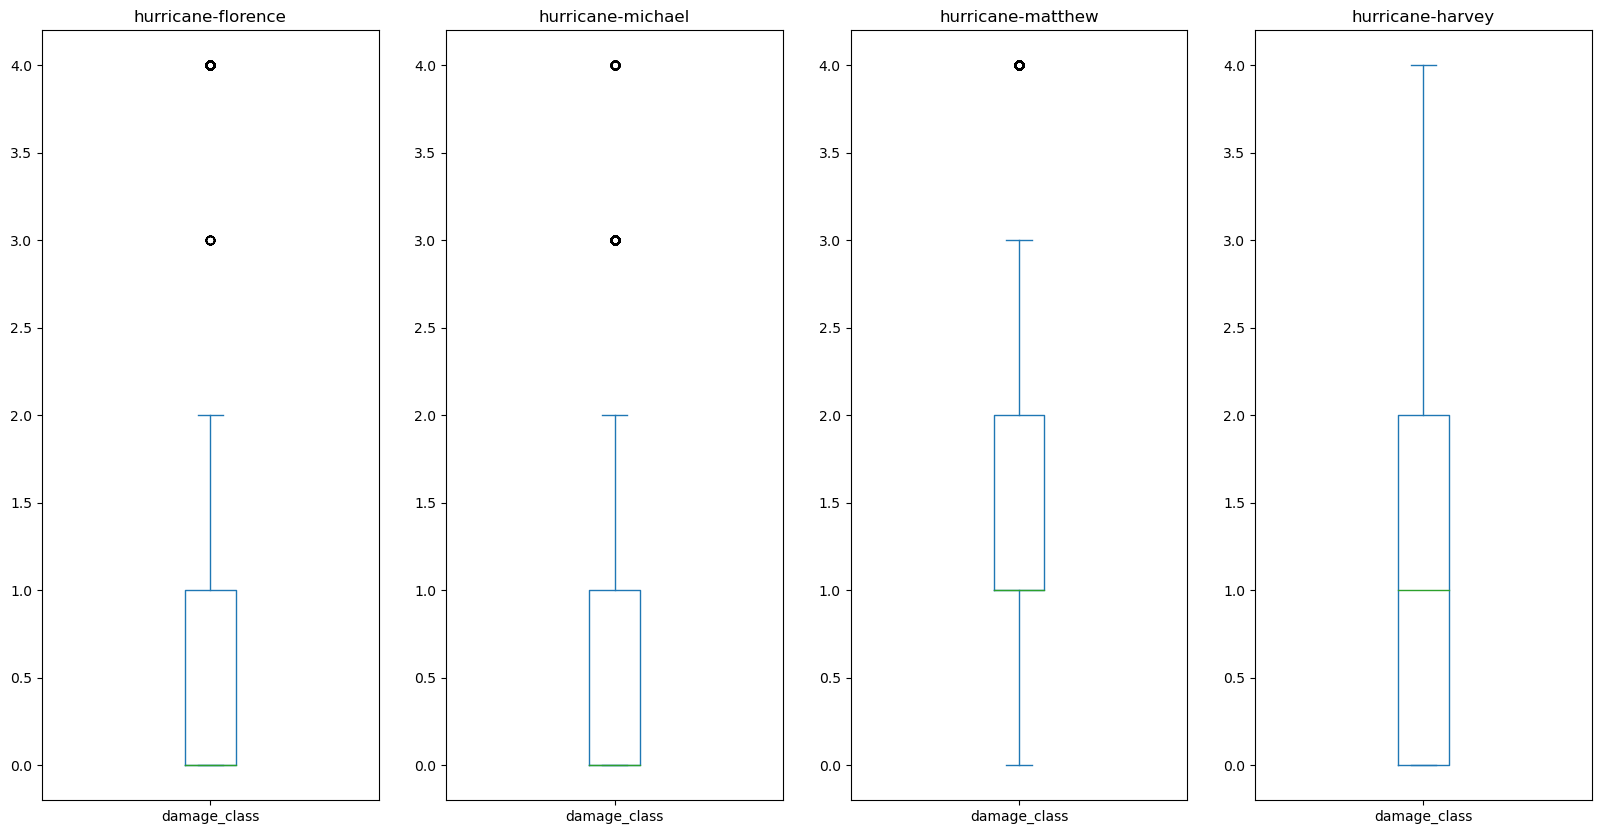

In [107]:
figs, axs = plt.subplots(1, len(num_disasters), figsize = (20,10))

for name, ax in zip(num_disasters, axs.ravel()):
  filtered_df = df[df['disaster_name'] == name]
  filtered_df["damage_class"].plot(kind='box', ax=ax)
  ax.set_title(name)

<AxesSubplot:>

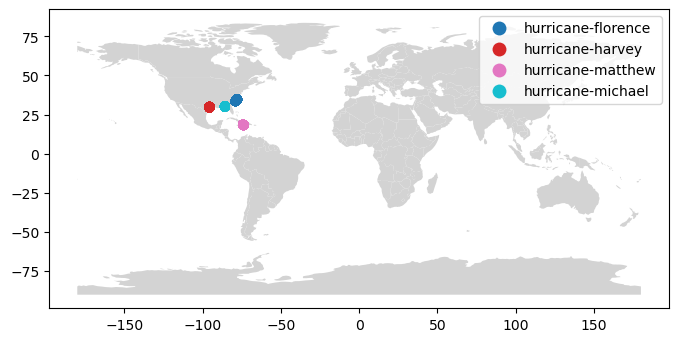

In [108]:
fig, ax = plt.subplots(figsize=(8,6))

countries.plot(color="lightgrey", ax=ax)
posthurr_points.plot(column = 'disaster_name',  ax=ax, legend = True)

(13.184576127444739, 39.89044980892358)

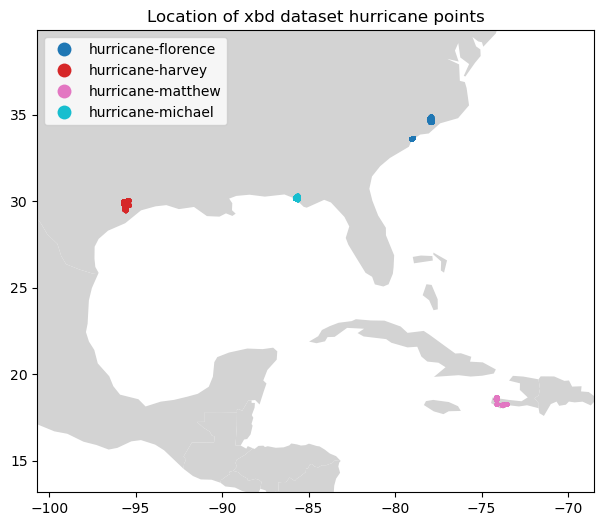

In [110]:
minx, miny, maxx, maxy = posthurr_points.total_bounds

fig, ax = plt.subplots(figsize=(8,6))

countries.plot(color="lightgrey", ax=ax)
posthurr_points.plot(column = 'disaster_name',  ax=ax, legend = True, s = 5)
ax.set_title("Location of xbd dataset hurricane points") # for only part a
ax.set_xlim(minx-5, maxx+5)
ax.set_ylim(miny-5, maxy+5)

Question: what do we do with unclassified?

# Load EF dataset polygons

In [173]:
full_post_hurr_json_files = [xbd_json_directory + "/" + i for i in posthurr_json_files]
df_pols_post_hurr = extract_damage_allfiles(full_post_hurr_json_files, 'polygon')

In [174]:
df_pols_post_hurr['capture_date'] = pd.to_datetime(df_pols_post_hurr['capture_date'])

In [184]:
dataset_path = data_directory + "/EFs/df_polygons_posthurr.pkl"

In [185]:
df_pols_post_hurr.to_pickle(dataset_path)

# Explore polygons

In [188]:
dataset_path = data_directory + "/EFs/df_polygons_posthurr.pkl"
posthurr_polygons = pd.read_pickle(dataset_path)

In [189]:
posthurr_polygons

,geometry,damage_class,disaster_name,capture_date
0,"POLYGON ((-73.74856 18.22257, -73.74853 18.222...",0,hurricane-matthew,2016-10-01 15:29:45+00:00
1,"POLYGON ((-73.74849 18.22249, -73.74844 18.222...",0,hurricane-matthew,2016-10-01 15:29:45+00:00
2,"POLYGON ((-73.74389 18.21841, -73.74394 18.218...",1,hurricane-matthew,2016-10-01 15:29:45+00:00
3,"POLYGON ((-73.74391 18.21849, -73.74394 18.218...",1,hurricane-matthew,2016-10-01 15:29:45+00:00
4,"POLYGON ((-73.74389 18.21899, -73.74391 18.218...",1,hurricane-matthew,2016-10-01 15:29:45+00:00
...,...,...,...,...
23049,"POLYGON ((-85.64412 30.22858, -85.64412 30.228...",0,hurricane-michael,2018-10-13 16:48:15+00:00
23050,"POLYGON ((-85.64479 30.22958, -85.64484 30.229...",0,hurricane-michael,2018-10-13 16:48:15+00:00
23051,"POLYGON ((-85.64478 30.22909, -85.64467 30.229...",0,hurricane-michael,2018-10-13 16:48:15+00:00
23052,"POLYGON ((-85.64485 30.22846, -85.64470 30.228...",1,hurricane-michael,2018-10-13 16:48:15+00:00


(13.184532400896138, 39.89052177529923)

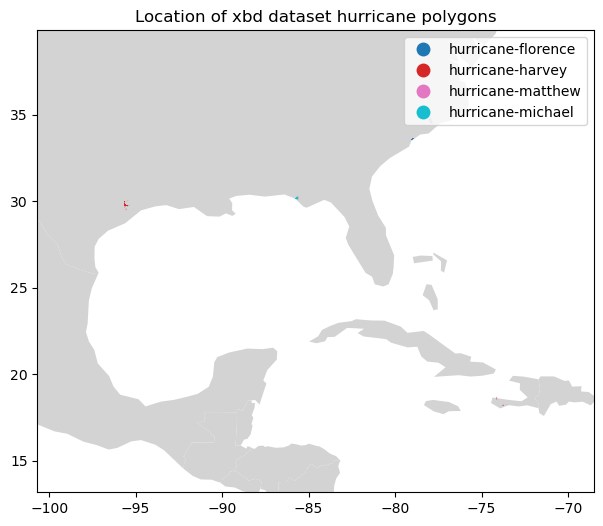

In [190]:
minx, miny, maxx, maxy = posthurr_polygons.total_bounds

fig, ax = plt.subplots(figsize=(8,6))

countries.plot(color="lightgrey", ax=ax)
posthurr_polygons.plot(column = 'disaster_name',  ax=ax, legend = True)
ax.set_title("Location of xbd dataset hurricane polygons") # for only part a
ax.set_xlim(minx-5, maxx+5)
ax.set_ylim(miny-5, maxy+5)